In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import networkx as nx
from itertools import combinations
from tqdm import tqdm


In [4]:
df=pd.read_csv(r"C:\Users\Yasaman\Downloads\co-attention.csv")
df=df.dropna()

In [5]:
df['countries_mentioned_list']=df['countries_mentioned'].apply(lambda x: x.split(','))
df['affiliations_list']=df['affiliations'].apply(lambda x: x.split(','))

In [15]:
df['Mention_number']=df['countries_mentioned_list'].apply(lambda x: len(x))

<Axes: xlabel='Mention_number', ylabel='Count'>

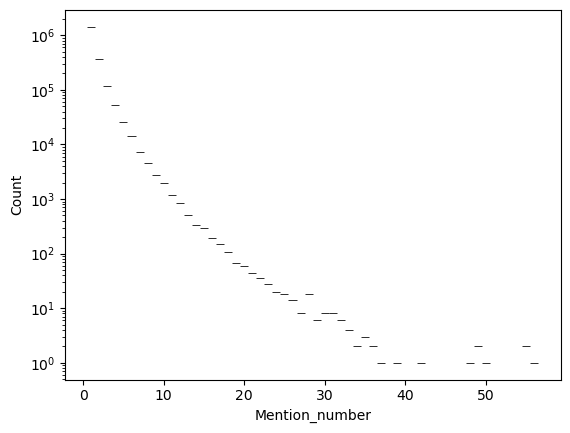

In [21]:
sns.histplot(data=df, x='Mention_number', discrete=True, bins=20, log_scale=(False, True))


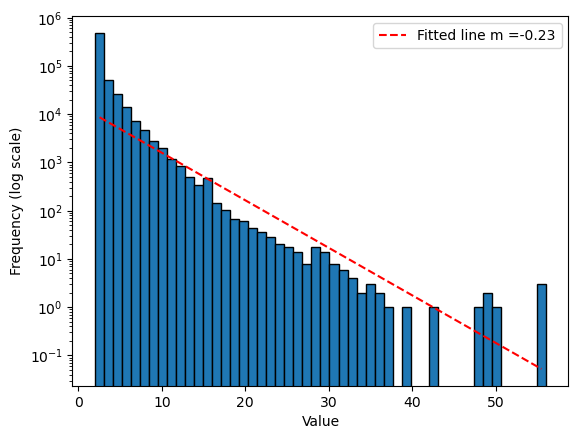

In [40]:
counts, bins, _ = plt.hist(df['Mention_number'], bins=50, edgecolor='black')
plt.yscale('log')
plt.xlabel('Value')
plt.ylabel('Frequency (log scale)')

# Fit a line to log(counts) vs bin centers
bin_centers = 0.5 * (bins[:-1] + bins[1:])
mask = counts > 0
coeffs = np.polyfit(bin_centers[mask], np.log(counts[mask]), 1)
plt.plot(bin_centers, np.exp(coeffs[1] + coeffs[0] * bin_centers), linestyle='--', label=f'Fitted line m ={np.round(coeffs[0], 2)}', color='red')
plt.legend()

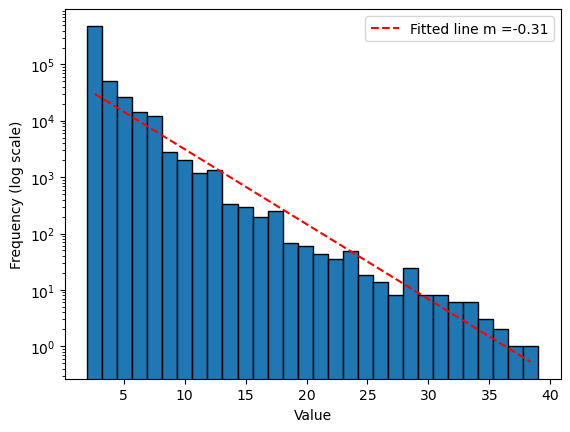

In [43]:
counts, bins, _ = plt.hist(df[df['Mention_number']<40]['Mention_number'], bins=30, edgecolor='black')
plt.yscale('log')
plt.xlabel('Value')
plt.ylabel('Frequency (log scale)')

# Fit a line to log(counts) vs bin centers
bin_centers = 0.5 * (bins[:-1] + bins[1:])
mask = counts > 0
coeffs = np.polyfit(bin_centers[mask], np.log(counts[mask]), 1)
plt.plot(bin_centers, np.exp(coeffs[1] + coeffs[0] * bin_centers), linestyle='--', label=f'Fitted line m ={np.round(coeffs[0], 2)}', color='red')
plt.legend()

In [45]:
data=df[df['Mention_number']<40]['Mention_number']
# Compute histogram
counts, bins = np.histogram(data, bins=50)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# Mask out zero counts
mask = counts > 0
x = bin_centers[mask]
log_counts = np.log(counts[mask])

# Fit linear model on log counts
coeffs = np.polyfit(x, log_counts, 1)
pred_log = coeffs[0] * x + coeffs[1]

# Calculate R^2 and RMSE
mean_log = np.mean(log_counts)
ss_tot = np.sum((log_counts - mean_log) ** 2)
ss_res = np.sum((log_counts - pred_log) ** 2)
r2 = 1 - ss_res / ss_tot
rmse = np.sqrt(np.mean((log_counts - pred_log) ** 2))

print(f"R² (coefficient of determination): {r2:.3f}")
print(f"RMSE on log scale: {rmse:.3f}")


R² (coefficient of determination): 0.945
RMSE on log scale: 0.797


In [46]:
data=df['Mention_number']
# Compute histogram
counts, bins = np.histogram(data, bins=50)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# Mask out zero counts
mask = counts > 0
x = bin_centers[mask]
log_counts = np.log(counts[mask])

# Fit linear model on log counts
coeffs = np.polyfit(x, log_counts, 1)
pred_log = coeffs[0] * x + coeffs[1]

# Calculate R^2 and RMSE
mean_log = np.mean(log_counts)
ss_tot = np.sum((log_counts - mean_log) ** 2)
ss_res = np.sum((log_counts - pred_log) ** 2)
r2 = 1 - ss_res / ss_tot
rmse = np.sqrt(np.mean((log_counts - pred_log) ** 2))

print(f"R² (coefficient of determination): {r2:.3f}")
print(f"RMSE on log scale: {rmse:.3f}")


R² (coefficient of determination): 0.845
RMSE on log scale: 1.349


In [23]:
df=df[df['Mention_number']>1].reset_index(drop=True)

In [25]:
def compute_period(year):
    if year in range(1998, 2004):
        return 'Period 1'
    elif year in range(2004, 2008):
        return 'Period 2'
    elif year in range(2008, 2012):
        return 'Period 3'
    elif year in range(2012, 2016):
        return 'Period 4'
    elif year in range(2016, 2019):
        return 'Period 5'
    elif year in range( 2019, 2023):
        return 'Period 6'

In [26]:
df['period']=df['Year'].apply(compute_period)

In [31]:
result_df=df.groupby(['countries_mentioned'])['aggregated_value'].sum().reset_index().sort_values(by='aggregated_value', ascending=False)

In [34]:
result_df['countries_mentioned_list']=result_df['countries_mentioned'].apply(lambda x: x.split(','))

result_df

,countries_mentioned,aggregated_value,countries_mentioned_list
92234,"usa, chn",16024,"[usa, chn]"
91950,"usa, can",15219,"[usa, can]"
97004,"usa, gbr",14189,"[usa, gbr]"
100786,"usa, mex",13581,"[usa, mex]"
14112,"chn, mng",8674,"[chn, mng]"
...,...,...,...
54370,"jam, bra, mex, bol",1,"[jam, bra, mex, bol]"
17231,"col, chl, ecu, cri, ury, arg, per, bra",1,"[col, chl, ecu, cri, ury, arg, per, bra]"
17232,"col, chl, ecu, cri, ury, arg, per, ven, bra, dom",1,"[col, chl, ecu, cri, ury, arg, per, ven..."
54367,"jam, blz, guy, brb, sur, dom",1,"[jam, blz, guy, brb, sur, dom]"


In [32]:
Graph = {f'Period {i}': nx.Graph() for i in range(1, 7)}

for i, row in tqdm(df.iterrows()):
    period = row.period
    possible_edges = row['countries_mentioned_list']
    if len(possible_edges) > 1:
        for u, v in combinations(possible_edges, 2):
            if Graph[period].has_edge(u, v):
                Graph[period][u][v]['weight'] += 1
            else:
                Graph[period].add_edge(u, v, weight=1)


2027574it [01:36, 20913.47it/s]


In [49]:
# Load coordinates from ISO3 codes
iso_df = pd.read_csv("https://gist.githubusercontent.com/tadast/8827699/raw/61b2107766d6fd51e2bd02d9f78f6be081340efc/countries_codes_and_coordinates.csv")
iso_df['Alpha-3 code']=iso_df['Alpha-3 code'].apply(lambda x: x.replace('\"', '').lower())
iso_df['Latitude (average)']=iso_df['Latitude (average)'].apply(lambda x: float(x.replace('\"', '').replace(' ', '')))
iso_df['Longitude (average)']=iso_df['Longitude (average)'].apply(lambda x: float(x.replace('\"', '').replace(' ', '')))

In [53]:
iso_coord_dict = iso_df.drop_duplicates('Alpha-3 code').set_index('Alpha-3 code')[['Longitude (average)', 'Latitude (average)']].to_dict('index')


In [ ]:
iso_df = iso_df[['Alpha-3 code', 'Latitude (average)', 'Longitude (average)']]
iso_df.columns = ['iso3', 'lat', 'lon']

iso_coord_dict = iso_df.set_index('iso3')[['lon', 'lat']].to_dict('index')


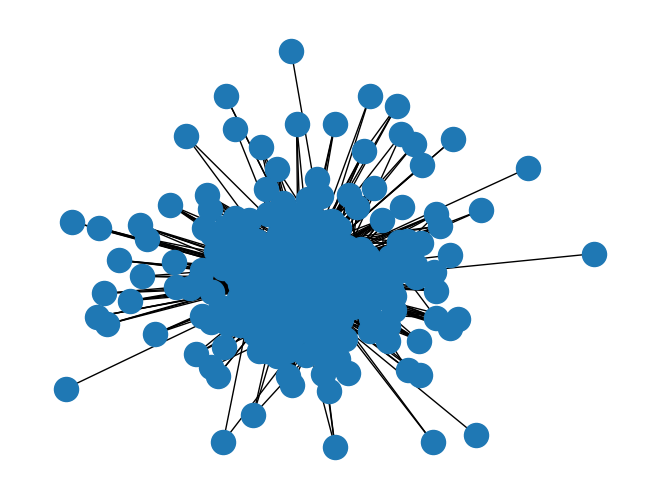

In [ ]:
nx.draw()

In [1]:
import plotly.graph_objects as go

edge_traces = []
G=Graph['Period 6']
for u, v, data in G.edges(data=True):
    if u in iso_coord_dict and v in iso_coord_dict and data['weight']>500:
        x0, y0 = iso_coord_dict[u]['Longitude (average)'], iso_coord_dict[u]['Latitude (average)']
        x1, y1 = iso_coord_dict[v]['Longitude (average)'], iso_coord_dict[v]['Latitude (average)']
        edge_traces.append(
            go.Scattergeo(
                lon=[x0, x1],
                lat=[y0, y1],
                mode='lines',
                line=dict(width=max(data['weight']/500, 1), color='blue'),
                opacity=0.5
            )
        )

# Node positions
node_trace = go.Scattergeo(
    lon=[iso_coord_dict[node]['Longitude (average)'] for node in G.nodes if node in iso_coord_dict],
    lat=[iso_coord_dict[node]['Latitude (average)'] for node in G.nodes if node in iso_coord_dict],
    mode='markers+text',
    text=[node for node in G.nodes if node in iso_coord_dict],
    marker=dict(size=5, color='red'),
    textposition='top center'
)

fig = go.Figure(data=edge_traces + [node_trace])
fig.update_layout(
    title='Country Network on Globe (ISO3)',
    showlegend=False,
    geo=dict(
        projection_type='orthographic',
        showland=True,
        landcolor='rgb(243, 243, 243)',
        showcountries=True,
        countrycolor='rgb(204, 204, 204)',
    ),
)
fig.show()


NameError: name 'Graph' is not defined